In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Import packages

In [8]:
import pandas as pd
import numpy as np
import fileinput
import re
import matplotlib.pyplot as plt
from IPython.display import HTML, display

In [9]:
%matplotlib inline

In [4]:
file_chargeOff = "c:/Data/IFRS/ZHOU CharegeOff 2006-2017.csv"
file_facility  = "c:/Data/IFRS/ZHOU ALL Facilities 2006-2017.csv"
file_fico      = "c:/Data/IFRS/ZHOU FICO by CustomerNumber.csv"

*Before* actually read files into *pandas* dataFrame, we have to take care of junk charaters in each file. 

In [3]:
# Following is a function that takes input files, and replace junk charcter with ''
# with this capacity we leverage more regex in this function later to repalce or manipulate other characters
def repalcechar(infile):
    '''
    This method might cause some problems:
        1. Python 2.7 and below will not support content manager with 'fileinput' module(a.k.a 'with')
        2. Redirect 'stdout' is not always a good idea
    '''     
    with fileinput.FileInput(infile,inplace=True) as file: #Set inplace=True to replace characters inplace
        for line in file:
            print(line.replace('[\x08-\xEF]',''), end='')
                  

In [62]:
# Method 2 to tackle this issue, we directly work on stdin stdout stream work
# Also, any leading zerose should be repalced with '' here
def delJunkChar(infile, outfile):
    '''
    Make sure have enough space to output files
    '''
    replaceBlank = ''
    for i in range(129,255):
        replaceBlank += chr(i)
    
    replaceBlank = '[' + replaceBlank + ']'
    
    
    with open(infile, 'r') as input, open(outfile,'w') as output:
        for line in input:
            
            # Step One: replace junk charactors
            line = re.sub(replaceBlank,'',line)
            
            #Step Two: remove any leading zeroes
            line = ','.join([re.sub(r'^0{2,}','',s) for s in line.split(sep=',')])
            
            # other criteria could be implemented here later
            output.write(line)
            

In [79]:
file_chargeOff_out = "c:/Data/IFRS/chargeoff.csv"
delJunkChar(file_chargeOff,file_chargeOff_out)

file_facility_out = "c:/Data/IFRS/facility.csv"
delJunkChar(file_facility, file_facility_out)

file_fico_out = "c:/Data/IFRS/fico.csv"
delJunkChar(file_fico, file_fico_out)

## Read in three seperated datasets 
     1. Charge off information
     2. Facility level information
     3. SBB FICO information
    
 However, the batch of files still need some data exclusion. Detail is listed in following sessions.

In [87]:
"""
Mixed types are exibited in sbbFacility, Becase the 'UBB' segment has different ways.
'CustomerNumber' and 'Facility Number' start with letter in 'UBB'
"""

sbbChargeOff = pd.read_csv(file_chargeOff_out, header = 0)
sbbFacility  = pd.read_csv(file_facility_out, header=0)
sbbFico      = pd.read_csv(file_fico_out, header=0)

"\nMixed types are exibited in sbbFacility, Becase the 'UBB' segment has different ways.\n'CustomerNumber' and 'Facility Number' start with letter in 'UBB'\n"

C:\Users\n814675\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data exclusion and transformation
    1. Continue to filter Facility and Charge off dataset by "Segment=SBB" and "SourceID=AFS"
    2. Facility file        
        a. Transform 'CustomerNumber', 'FacilityNumber' to 'int'
    3. FICO file
        a. FICO cut-off [400,900]
        b. Time stamp for 'asofdate'
    4. Charge-off file
        a. Tiem stamp for 'CO_Date'

### Include only *"Segment=SBB"* and *"SourceID=AFS"*

In [109]:
sbbFacility  = sbbFacility[(sbbFacility.Segment == 'SBB') & (sbbFacility.SourceID == 'AFS')]
sbbChargeOff = sbbChargeOff[sbbChargeOff.SourceID == 'AFS']

# """
# If we want to check wether any zero leading 'CustomerNumber'
# sbbFacility[sbbFacility.CustomerNumber.str.match('^0+') == True]
# """

## Transform "Facility" dataset

In [175]:
# Convert  'CustomerNubmer' from 'str' to 'int'
sbbFacility.CustomerNumber = sbbFacility.CustomerNumber.apply(int)


# Convert all 'FacilityNumber' to 'str', 'int' will cause 
# 'becasue Python int too large to convert to C long'
sbbFacility.FacilityNumber = sbbFacility.FacilityNumber.apply(int)

# Convert 'Segment' and 'SourceID'  to 'str'
sbbFacility[['Segment', 'SourceID']] = sbbFacility[['Segment', 'SourceID']].astype('str')

# Convert 'asofdate' to date time format
sbbFacility.asofdate = pd.to_datetime(sbbFacility.asofdate)

# Convert all bin variables to 'int'
binList = [col for col in sbbFacility.columns if 'Bucket' in col or 'DPD' in col ]
sbbFacility[binList] = sbbFacility[binList].fillna(-1) # fill missing values with -1
sbbFacility[binList] = sbbFacility[binList].astype(int)


In [178]:
sbbFacility.info() # Check if all format is correct

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3036795 entries, 0 to 3929926
Data columns (total 16 columns):
asofdate                 datetime64[ns]
SourceID                 object
Segment                  object
CustomerNumber           int64
FacilityNumber           int64
LTV                      float64
BookBalanceAmount        float64
BindingExposureAmount    float64
Bucket_30to59            int32
Bucket_60to89            int32
Bucket_90to119           int32
Bucket_120               int32
DPD30_IND                int32
DPD60_IND                int32
DPD90_IND                int32
DPD120_IND               int32
dtypes: datetime64[ns](1), float64(3), int32(8), int64(2), object(2)
memory usage: 301.2+ MB


In [24]:
# apply to each str element to delete leading zeroes
# rmLeadZero = lambda s: s.str.replace(r'^(0)+','')

# sbbChargeOff[['CustomerNumber', 'FacilityNumber']] = sbbChargeOff[['CustomerNumber', 'FacilityNumber']].applymap(rmLeadZero)
# sbbFacility[['CustomerNumber', 'FacilityNumber']] = sbbFacility[['CustomerNumber', 'FacilityNumber']].applymap(rmLeadZero)

In [147]:
sbbFacility.describe() # Need to improve describe output

,CustomerNumber,FacilityNumber,LTV,BookBalanceAmount,BindingExposureAmount,Bucket_30to59,Bucket_60to89,Bucket_90to119,Bucket_120,DPD30_IND,DPD60_IND,DPD90_IND,DPD120_IND
count,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06
mean,5.165909e+07,5.165909e+17,3.547013e-01,3.975078e+04,6.386984e+04,2.416126e+02,1.451608e+02,1.191591e+02,3.932641e+02,-1.037327e-01,-1.053739e-01,-1.057714e-01,-9.992640e-02
std,5.943627e+05,5.943627e+15,5.281769e+00,6.780343e+04,7.362214e+04,5.960729e+03,4.308513e+03,3.634550e+03,7.135731e+03,3.140225e-01,3.117218e-01,3.111916e-01,3.202455e-01
min,5.000005e+07,5.000005e+17,0.000000e+00,-2.337709e+05,1.000000e-02,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,5.121012e+07,5.121012e+17,0.000000e+00,0.000000e+00,2.352321e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.172604e+07,5.172604e+17,0.000000e+00,1.914811e+04,5.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.215005e+07,5.215005e+17,0.000000e+00,4.950000e+04,8.522930e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.269922e+07,5.269922e+17,8.500000e+02,9.246000e+06,1.100000e+07,1.100000e+06,1.100000e+06,1.100000e+06,9.507700e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### FICO files  

In [163]:
sbbFico[sbbFico.FICO.isnull()] # No missing values

,CustomerNumber,asofdate,FICO


In [164]:
# Convert 'asofdate' from 'str' to 'datetime'

# If we need to further convert the date to Quarter then uncomment the following code
#sbbFacility.asofdate.dt.to_period('Q')

sbbFico.asofdate     = pd.to_datetime(sbbFico.asofdate)

In [165]:
# Check FIOC formats
sbbFico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2404587 entries, 0 to 2404586
Data columns (total 3 columns):
CustomerNumber    int64
asofdate          datetime64[ns]
FICO              int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 55.0 MB


### Charge-off file

In [181]:
sbbChargeOff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10327 entries, 0 to 14229
Data columns (total 6 columns):
CO_Date            10327 non-null datetime64[ns]
SourceID           10327 non-null object
CustomerNumber     10327 non-null int64
FacilityNumber     10327 non-null int64
ChargeOffAmount    10327 non-null float64
RecoveryAmount     10327 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 564.8+ KB


In [179]:
sbbChargeOff.CO_Date = pd.to_datetime(sbbChargeOff.CO_Date)

# Convert 'CustomerNumber' and 'FacilityNubmer' to 'int'
sbbChargeOff[['CustomerNumber', 'FacilityNumber']] = sbbChargeOff[['CustomerNumber', 'FacilityNumber']].astype('int64')


# Convert 'SourceID' to 'str'
sbbChargeOff.SourceID = sbbChargeOff.SourceID.apply(str)

## Data exploture anaysis
    1. List variable names from each dataset
    2. Missing values from each variable
    3. Check Time horizon from each source
    4. check FICO data quality
    5. Check unique customer from 'Faciliyt', 'FICO' and 'Charge-off'

### List variable names

In [244]:
something = pd.DataFrame([sbbFacility.columns, sbbFico.columns, sbbChargeOff.columns]).T
something.columns = ['Facility', 'FICO', 'Charge-off']
something

,Facility,FICO,Charge-off
0,asofdate,CustomerNumber,CO_Date
1,SourceID,asofdate,SourceID
2,Segment,FICO,CustomerNumber
3,CustomerNumber,None,FacilityNumber
4,FacilityNumber,None,ChargeOffAmount
5,LTV,None,RecoveryAmount
6,BookBalanceAmount,None,None
7,BindingExposureAmount,None,None
8,Bucket_30to59,None,None
9,Bucket_60to89,None,None


### Check missing values

In [186]:
sbbFacility.describe()

,CustomerNumber,FacilityNumber,LTV,BookBalanceAmount,BindingExposureAmount,Bucket_30to59,Bucket_60to89,Bucket_90to119,Bucket_120,DPD30_IND,DPD60_IND,DPD90_IND,DPD120_IND
count,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06,3.036795e+06
mean,5.165909e+07,5.165909e+17,3.547013e-01,3.975078e+04,6.386984e+04,2.416126e+02,1.451608e+02,1.191591e+02,3.932641e+02,-1.037327e-01,-1.053739e-01,-1.057714e-01,-9.992640e-02
std,5.943627e+05,5.943627e+15,5.281769e+00,6.780343e+04,7.362214e+04,5.960729e+03,4.308513e+03,3.634550e+03,7.135731e+03,3.140225e-01,3.117218e-01,3.111916e-01,3.202455e-01
min,5.000005e+07,5.000005e+17,0.000000e+00,-2.337709e+05,1.000000e-02,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,5.121012e+07,5.121012e+17,0.000000e+00,0.000000e+00,2.352321e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.172604e+07,5.172604e+17,0.000000e+00,1.914811e+04,5.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.215005e+07,5.215005e+17,0.000000e+00,4.950000e+04,8.522930e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.269922e+07,5.269922e+17,8.500000e+02,9.246000e+06,1.100000e+07,1.100000e+06,1.100000e+06,1.100000e+06,9.507700e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Check Time horizon on all datasets

In [298]:
timeTable = pd.DataFrame({'Min':[sbbFacility.asofdate.min(),sbbFico.asofdate.min(), sbbChargeOff.CO_Date.min()],
                          'Max':[sbbFacility.asofdate.max(),sbbFico.asofdate.max(), sbbChargeOff.CO_Date.max()]                       
            
        
    },index = ['Faclity', 'FICO', 'Charge-off'])
timeTable

,Max,Min
Faclity,2017-04-30,2007-03-31
FICO,2017-04-30,2006-12-31
Charge-off,2017-04-30,2007-01-31


### Check FICO sore range and distribution
    1. Stats summary table
    2. Distribution anaylsis

In [297]:


Check any missing values from FICO score
print("Number of missing FICO score:", sbbFico.FICO[sbbFico.FICO.isnull()].count())

# List summary table
pd.DataFrame(sbbFico.FICO.describe(percentiles=np.arange(0.10,1.0,0.05)).astype(int))

# Check out of range FICO scores, we define the max FICO = 900, min FICO = 400
print('Number of out-of-range FICO:' ,sbbFico.FICO[(sbbFico.FICO > 900) | (sbbFico.FICO < 400)].count())


Number of missing FICO score: 0


,FICO
count,2404587
mean,774
std,683
min,0
10%,560
15.0%,630
20.0%,665
25.0%,687
30.0%,704
35.0%,719


Number of out-of-range FICO: 190194


In [ ]:
# Open one plt figure object
plt.figure()

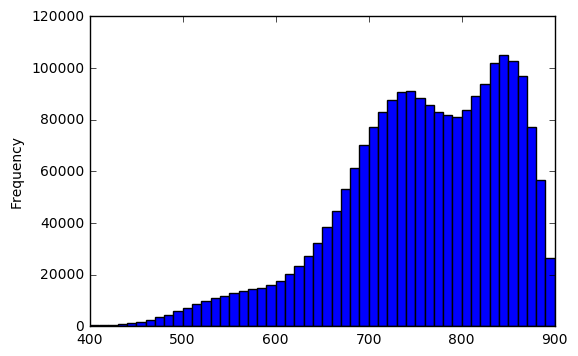

In [294]:
sbbFico.FICO[(sbbFico.FICO <= 900) & (sbbFico.FICO >= 400)].plot.hist(bins=50)

### Check unique Custerm Numbers 

In [205]:
# We're sopposed to merge 'Facility' with 'Fico'
dataTable =pd.DataFrame({
        'Unique Custerm Number':[sbbFico.CustomerNumber.nunique(), sbbFacility.CustomerNumber.nunique(), 
                                abs(sbbFico.CustomerNumber.nunique() - sbbFacility.CustomerNumber.nunique())]
        
    }, index = ['Fico', 'Facility', 'Difference'])

dataTable

,Unique Custerm Number
Fico,52301
Facility,90335
Difference,38034


However, we should also double check wether we have some cumstomers with FICO but no facility history

### Pull how many Customer who doesn't have FICO score

In [ ]:
sbbFacility[~sbbFacility.CustomerNumber.isin(sbbFico.CustomerNumber)]

In [206]:
sbbFacility.CustomerNumber[sbbFacility.CustomerNumber.isin(sbbFico.CustomerNumber)].nunique()

45912

In [119]:
# Drop all the Buckets, most of them contain wrong values
sbbFacility = sbbFacility.drop(['Bucket_30to59','Bucket_60to89', 'Bucket_90to119', 'Bucket_120'],axis=1)

In [122]:
# Replace missing values with '0', and make all indicators to type 'int'
sbbFacility[['DPD30_IND','DPD60_IND', 'DPD90_IND', 'DPD120_IND']] = sbbFacility[['DPD30_IND','DPD60_IND', 'DPD90_IND', 'DPD120_IND']].fillna(0).astype(int)

## Track Customer FICO history

In [450]:
sbbFico      = pd.read_csv(file_fico_out, header=0)
sbbFico.asofdate     = pd.to_datetime(sbbFico.asofdate)

In [451]:
sbbFico = sbbFico.sort_values(['CustomerNumber','asofdate'])
ficoOrig = sbbFico.groupby('CustomerNumber').first().reset_index()

ficoOrig = ficoOrig.rename(index= str, columns={'FICO': 'FICO_orig'}).drop('asofdate',axis = 1)

In [452]:
sbbFico = pd.merge(sbbFico,ficoOrig,on = 'CustomerNumber', how ='inner')
sbbFico['FICO_diff'] = sbbFico.FICO - sbbFico.FICO_orig

In [ ]:
sbbFico.head(109)

# Merge tables 
   ## 1.Merge FICO with Facility

In [454]:
sbbFacFico_left = pd.merge(sbbFacility, sbbFico, on = ['CustomerNumber','asofdate'], how = 'left')

In [503]:
# Left join with facility peformance data

sbbFacFico = pd.merge(sbbFacFico_left, sbbChargeOff, on = ['CustomerNumber', 'FacilityNumber']
                       ,how = 'left')

# Keep data after 2010-01-01
dropList = [col for col in sbbFacFico.columns if 'Bucket' in col]
sbbFacFico = sbbFacFico[sbbFacFico.asofdate >= pd.to_datetime('2010-01-01')]
sbbFacFico = sbbFacFico.drop(dropList,axis=1)

In [504]:
sbbFacFico = sbbFacFico.sort_values(['CustomerNumber', 'asofdate'])
sbbFacFico.head(120)

,asofdate,SourceID_x,Segment,CustomerNumber,FacilityNumber,LTV,BookBalanceAmount,BindingExposureAmount,DPD30_IND,DPD60_IND,DPD90_IND,DPD120_IND,FICO,FICO_orig,FICO_diff,CO_Date,SourceID_y,ChargeOffAmount,RecoveryAmount
957430,2010-01-31,AFS,SBB,50000046,500000460000000034,0.0,19554.05,19554.05,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaN
984739,2010-02-28,AFS,SBB,50000046,500000460000000034,0.0,18180.30,18180.30,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1011849,2010-03-31,AFS,SBB,50000046,500000460000000034,0.0,16791.71,16791.71,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1038739,2010-04-30,AFS,SBB,50000046,500000460000000034,0.0,15404.88,15404.88,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1065405,2010-05-31,AFS,SBB,50000046,500000460000000034,0.0,14009.12,14009.12,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1091866,2010-06-30,AFS,SBB,50000046,500000460000000034,0.0,12609.11,12609.11,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1118145,2010-07-31,AFS,SBB,50000046,500000460000000034,0.0,11200.54,11200.54,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1144379,2010-08-31,AFS,SBB,50000046,500000460000000034,0.0,9787.23,9787.23,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1170385,2010-09-30,AFS,SBB,50000046,500000460000000034,0.0,8367.22,8367.22,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1196171,2010-10-31,AFS,SBB,50000046,500000460000000034,0.0,6939.21,6939.21,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaN


## Define 'PD_Flag'
### PD_flag: DPD=90 or Charge-off file as PD
### PD_Current: 1. CO_date within quarter of Date;  2. Group by customer date, if first.pd then pd_current = 1

In [505]:
# Define 'Default' is DPD90 or from charge-off files
sbbFacFico['PD_flag'] = np.where((sbbFacFico.CO_Date.notnull() & (sbbFacFico.CO_Date <= sbbFacFico.asofdate)) | (sbbFacFico.DPD90_IND == 1),1,0)


#Find the first 'default' time point
# sbbFacFico['PD_current'] = ((sbbFacFico.PD_flag == 1) 
#                             & (sbbFacFico.asofdate.dt.to_period('Q') == sbbFacFico.CO_Date.dt.to_period('Q'))).astype(int)




In [559]:
# check PD rate
sbbFacFico['year'] = sbbFacFico.asofdate.dt.year
yearPD = sbbFacFico.groupby(['year'])
yearPD['PD_flag'].sum()/yearPD['PD_flag'].count()

In [506]:
# Construct a first PD date table:
# 1. if CO_date, then as pd_date

# 2. if DPD90, then asofdate as pd_date

firstPD = sbbFacFico[sbbFacFico.PD_flag == 1].groupby(['CustomerNumber']).first().reset_index()

firstPD = firstPD[['CustomerNumber','asofdate']].rename(index= str, columns= {'asofdate':'PD_date'})

In [507]:
# Merge PD_date backinto dataset
sbbFacFico = pd.merge(sbbFacFico, firstPD, on = ['CustomerNumber'], how='left')

In [508]:
# Fill some missing values
sbbFacFico[['FICO', 'FICO_orig', 'FICO_diff']] = sbbFacFico[['FICO', 'FICO_orig', 'FICO_diff']].fillna(0).astype(int)

In [517]:
# Set up stage information 
def f(row):
    if row.DPD90_IND:
        val =3
    elif row.DPD30_IND or row.FICO_diff <= -150:
        val = 2
    else:
        val = 1
    return val

In [518]:
sbbFacFico['Stage'] = sbbFacFico.apply(f,axis=1)

(1    1983768
 3      48428
 2      47169
 Name: Stage, dtype: int64,)

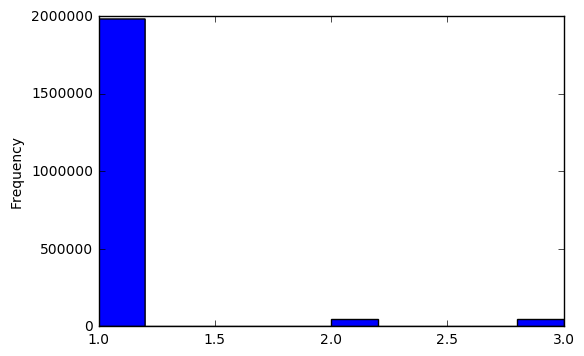

In [553]:
# Stage distribution
# sbbFico.FICO[(sbbFico.FICO <= 900) & (sbbFico.FICO >= 400)].plot.hist(bins=50)
sbbFacFico.Stage.value_counts(),
sbbFacFico.Stage.astype(int).plot.hist()

1    20140
3     1329
2      492
Name: Stage, dtype: int64


(None,)

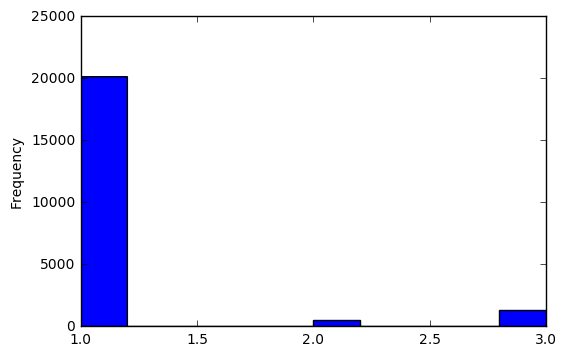

In [556]:
# Stage distribution
# sbbFico.FICO[(sbbFico.FICO <= 900) & (sbbFico.FICO >= 400)].plot.hist(bins=50)
print(sbbFacFico[sbbFacFico.asofdate == pd.to_datetime('2016-12-31')].Stage.value_counts()),
sbbFacFico[sbbFacFico.asofdate == pd.to_datetime('2016-12-31')].Stage.astype(int).plot.hist()

In [535]:
# One year later
sbbFacFico['Oneyear'] = sbbFacFico.asofdate + pd.DateOffset(years = 1)
sbbOneYear = sbbFacFico[['CustomerNumber', 'asofdate', 'PD_flag']].rename(index =str, columns ={'PD_flag': 'PD_oneyear'})

sbbFacFico_Oneyear = pd.merge(sbbFacFico, sbbOneYear, how='left', 
                left_on=['CustomerNumber', 'Oneyear'],
                right_on = ['CustomerNumber','asofdate'])


In [536]:
testPD = sbbFacFico_Oneyear[sbbFacFico_Oneyear.PD_oneyear.notnull()]

In [548]:
sbbFacFico_Oneyear[sbbFacFico_Oneyear.Stage == 3 ]

,asofdate_x,SourceID_x,Segment,CustomerNumber,FacilityNumber,LTV,BookBalanceAmount,BindingExposureAmount,DPD30_IND,DPD60_IND,...,CO_Date,SourceID_y,ChargeOffAmount,RecoveryAmount,PD_flag,PD_date,Stage,Oneyear,asofdate_y,PD_oneyear
86,2010-12-31,AFS,SBB,50000285,500002850000000034,0.0,508590.87,508590.87,0,0,...,NaT,NaN,NaN,NaN,1,2010-12-31,3,2011-12-31,NaT,NaN
747,2015-08-31,AFS,SBB,50003016,500030160000000042,0.0,0.00,50000.00,-1,-1,...,NaT,NaN,NaN,NaN,0,NaT,3,2016-08-31,2016-08-31,0.0
748,2015-09-30,AFS,SBB,50003016,500030160000000042,0.0,0.00,50000.00,-1,-1,...,NaT,NaN,NaN,NaN,0,NaT,3,2016-09-30,2016-09-30,0.0
749,2015-10-31,AFS,SBB,50003016,500030160000000042,0.0,0.00,50000.00,-1,-1,...,NaT,NaN,NaN,NaN,0,NaT,3,2016-10-31,2016-10-31,0.0
750,2015-11-30,AFS,SBB,50003016,500030160000000042,0.0,0.00,50000.00,-1,-1,...,NaT,NaN,NaN,NaN,0,NaT,3,2016-11-30,2016-11-30,0.0
751,2015-12-31,AFS,SBB,50003016,500030160000000042,0.0,0.00,50000.00,-1,-1,...,NaT,NaN,NaN,NaN,0,NaT,3,2016-12-31,2016-12-31,0.0
752,2016-01-31,AFS,SBB,50003016,500030160000000042,0.0,0.00,50000.00,-1,-1,...,NaT,NaN,NaN,NaN,0,NaT,3,2017-01-31,2017-01-31,0.0
753,2016-02-29,AFS,SBB,50003016,500030160000000042,0.0,0.00,50000.00,-1,-1,...,NaT,NaN,NaN,NaN,0,NaT,3,2017-02-28,2017-02-28,0.0
754,2016-03-31,AFS,SBB,50003016,500030160000000042,0.0,0.00,50000.00,-1,-1,...,NaT,NaN,NaN,NaN,0,NaT,3,2017-03-31,2017-03-31,0.0
755,2016-04-30,AFS,SBB,50003016,500030160000000042,0.0,0.00,50000.00,-1,-1,...,NaT,NaN,NaN,NaN,0,NaT,3,2017-04-30,2017-04-30,0.0


In [545]:
PDGroup = testPD[testPD.PD_flag == 0].groupby(['Stage','PD_oneyear'])

In [547]:
PDGroup[['CustomerNumber']].count()

CustomerNumber
Stage PD_oneyear                
1     0.0                1691011
      1.0                   6554
2     0.0                  32090
      1.0                   1194
3     0.0                  27610
      1.0                      2

In [528]:
sbbOneYear[sbbOneYear.CustomerNumber == 50000046]

,CustomerNumber,asofdate,PD_flag,Oneyear
0,50000046,2010-01-31,0,2011-01-31
1,50000046,2010-02-28,0,2011-02-28
2,50000046,2010-03-31,0,2011-03-31
3,50000046,2010-04-30,0,2011-04-30
4,50000046,2010-05-31,0,2011-05-31
5,50000046,2010-06-30,0,2011-06-30
6,50000046,2010-07-31,0,2011-07-31
7,50000046,2010-08-31,0,2011-08-31
8,50000046,2010-09-30,0,2011-09-30
9,50000046,2010-10-31,0,2011-10-31


In [521]:
sbbFacFico.head()

,asofdate,SourceID_x,Segment,CustomerNumber,FacilityNumber,LTV,BookBalanceAmount,BindingExposureAmount,DPD30_IND,DPD60_IND,...,FICO_orig,FICO_diff,CO_Date,SourceID_y,ChargeOffAmount,RecoveryAmount,PD_flag,PD_date,Stage,Oneyear
0,2010-01-31,AFS,SBB,50000046,500000460000000034,0.0,19554.05,19554.05,0,0,...,0,0,NaT,NaN,NaN,NaN,0,NaT,1,2011-01-31
1,2010-02-28,AFS,SBB,50000046,500000460000000034,0.0,18180.30,18180.30,0,0,...,0,0,NaT,NaN,NaN,NaN,0,NaT,1,2011-02-28
2,2010-03-31,AFS,SBB,50000046,500000460000000034,0.0,16791.71,16791.71,0,0,...,0,0,NaT,NaN,NaN,NaN,0,NaT,1,2011-03-31
3,2010-04-30,AFS,SBB,50000046,500000460000000034,0.0,15404.88,15404.88,0,0,...,0,0,NaT,NaN,NaN,NaN,0,NaT,1,2011-04-30
4,2010-05-31,AFS,SBB,50000046,500000460000000034,0.0,14009.12,14009.12,0,0,...,0,0,NaT,NaN,NaN,NaN,0,NaT,1,2011-05-31


In [385]:
sbbFacFico[sbbFacFico.CustomerNumber == 50162960][['asofdate','FICO','PD_flag']].sort_values('asofdate')

,asofdate,FICO,PD_flag
25,2007-03-31,159,0
26159,2007-06-30,153,0
53038,2007-09-30,0,0
81277,2007-12-31,156,0
131927,2008-05-31,547,0
154880,2008-06-30,516,0
183474,2008-07-31,516,0
210299,2008-08-31,493,0
237003,2008-09-30,514,0
263660,2008-10-31,514,0


In [231]:
sbbGroupby = sbbFacFico[sbbFacFico['PD_flag'] == 1].groupby(['CustomerNumber', 'asofdate'])

In [182]:
sbbFico.CustomerNumber.nunique() ,    sbbFacility.CustomerNumber.nunique(), sbbFacility.Segment.value_counts()

(52301, 90335, SBB    3036795
 Name: Segment, dtype: int64)